# Importing Libraries

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Regression models 
from sklearn.linear_model import LinearRegression

# Classification models 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# Pipelines & metrics
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Clustering 
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Plotting 
import matplotlib.pyplot as plt
import seaborn as sns

# Loading data

In [3]:
df = pd.read_csv("_cancer_dataset_uae.csv")

need_cols = ['Age','Gender','Cancer_Type','Cancer_Stage','Smoking_Status',
             'Comorbidities','Weight','Height','Treatment_Type']
df = df[need_cols].copy()

# Create BMI
df['BMI'] = df.apply(lambda r: r['Weight'] / ((r['Height']/100.0)**2) if pd.notnull(r['Weight']) and pd.notnull(r['Height']) and r['Height']>0 else 
                     np.nan, axis=1)

for c in ['Age','Weight','Height','BMI']:
    df[c] = df[c].fillna(df[c].median())
for c in ['Gender','Cancer_Type','Cancer_Stage','Smoking_Status','Comorbidities','Treatment_Type']:
    df[c] = df[c].fillna(df[c].mode().iloc[0])

# 1) Simple Regression 

In [4]:
reg_simple_df = df[['Age','BMI']].dropna()
X_sr = reg_simple_df[['Age']].values
y_sr = reg_simple_df['BMI'].values

X_sr_train, X_sr_test, y_sr_train, y_sr_test = train_test_split(X_sr, y_sr, test_size=0.2, random_state=42)

linreg_simple = LinearRegression()
linreg_simple.fit(X_sr_train, y_sr_train)
sr_r2 = linreg_simple.score(X_sr_test, y_sr_test)

print("Simple Regression (BMI ~ Age)")
print("  R^2 on test:", round(sr_r2, 3))

Simple Regression (BMI ~ Age)
  R^2 on test: -0.003


# 2) Multiple Linear Regression 

In [5]:
reg_multi_df = df[['Age','Weight','Height','BMI']].dropna()
X_mr = reg_multi_df[['Age','Weight','Height']]
y_mr = reg_multi_df['BMI']

X_mr_train, X_mr_test, y_mr_train, y_mr_test = train_test_split(X_mr, y_mr, test_size=0.2, random_state=42)

linreg_multi = LinearRegression()
linreg_multi.fit(X_mr_train, y_mr_train)
mr_r2 = linreg_multi.score(X_mr_test, y_mr_test)

print("\nMultiple Linear Regression (BMI ~ Age + Weight + Height)")
print("  R^2 on test:", round(mr_r2, 3))


Multiple Linear Regression (BMI ~ Age + Weight + Height)
  R^2 on test: 0.985


# 3) Classification models 

In [6]:
target = 'Treatment_Type'
features = ['Age','Gender','Cancer_Type','Cancer_Stage','Smoking_Status','Comorbidities','BMI']

X = df[features].copy()
y = df[target].copy()

num_cols = ['Age','BMI']
cat_cols = ['Gender','Cancer_Type','Cancer_Stage','Smoking_Status','Comorbidities']

preprocess_common = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

In [7]:
# LR (multinomial)
pipe_lr = Pipeline(steps=[
    ('prep', preprocess_common),
    ('clf', LogisticRegression(max_iter=1000, multi_class='auto'))
])

In [8]:
# KNN (K=5)
pipe_knn = Pipeline(steps=[
    ('prep', preprocess_common),
    ('clf', KNeighborsClassifier(n_neighbors=5))
])

In [9]:
# Decision Tree
pipe_dt = Pipeline(steps=[
    ('prep', preprocess_common),
    ('clf', DecisionTreeClassifier(random_state=42))
])

In [11]:
# Naïve Bayes
preprocess_nb = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_cols),  # GaussianNB okay with raw nums
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ],
    remainder='drop'
)

pipe_nb = Pipeline(steps=[
    ('prep', preprocess_nb),
    ('clf', GaussianNB())
])

In [12]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Train & evaluate
models = {
    'LogisticRegression': pipe_lr,
    'KNN': pipe_knn,
    'NaiveBayes': pipe_nb,
    'DecisionTree': pipe_dt
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    cm = confusion_matrix(y_test, preds, labels=sorted(y.unique()))
    results[name] = {'acc': acc, 'cm': cm, 'preds': preds}
    print(f"\n=== {name} ===")
    print("Accuracy:", round(acc, 3))
    print("Confusion Matrix (rows=true, cols=pred):")
    print(pd.DataFrame(cm, index=sorted(y.unique()), columns=sorted(y.unique())))
    # Optional full report for your appendix:
    print("\nClassification Report:")
    print(classification_report(y_test, preds))

C:\Users\MB771\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== LogisticRegression ===
Accuracy: 0.241
Confusion Matrix (rows=true, cols=pred):
               Chemotherapy  Immunotherapy  Radiation  Surgery
Chemotherapy             97            138        118      144
Immunotherapy           107            115        128      149
Radiation               113            121        119      151
Surgery                 109            123        117      151

Classification Report:
               precision    recall  f1-score   support

 Chemotherapy       0.23      0.20      0.21       497
Immunotherapy       0.23      0.23      0.23       499
    Radiation       0.25      0.24      0.24       504
      Surgery       0.25      0.30      0.28       500

     accuracy                           0.24      2000
    macro avg       0.24      0.24      0.24      2000
 weighted avg       0.24      0.24      0.24      2000


=== KNN ===
Accuracy: 0.262
Confusion Matrix (rows=true, cols=pred):
               Chemotherapy  Immunotherapy  Radiation  Surgery


In [13]:

best_name = max(results, key=lambda k: results[k]['acc'])
best_model = models[best_name]
print(f"\n>>> Best classifier by accuracy: {best_name} (acc={results[best_name]['acc']:.3f})")



>>> Best classifier by accuracy: KNN (acc=0.262)


# 5) Predict with best-fit classifier

In [14]:
best_preds = results[best_name]['preds']
preview = pd.DataFrame({
    'True': y_test.reset_index(drop=True).head(10),
    'Pred': pd.Series(best_preds).head(10)
})
print("\nSample predictions (first 10):")
print(preview)


Sample predictions (first 10):
            True           Pred
0   Chemotherapy      Radiation
1        Surgery        Surgery
2      Radiation  Immunotherapy
3      Radiation   Chemotherapy
4  Immunotherapy  Immunotherapy
5  Immunotherapy   Chemotherapy
6        Surgery      Radiation
7        Surgery        Surgery
8  Immunotherapy  Immunotherapy
9  Immunotherapy      Radiation


# 6) Clustering - KMeans & Hierarchical

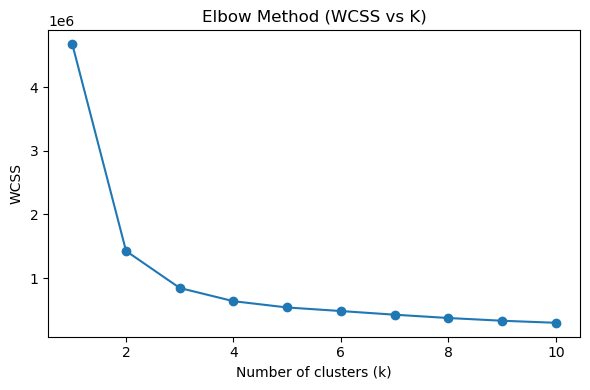

In [15]:
cluster_df = df[['Age','BMI']].dropna().copy()

# -- Elbow method for KMeans --
wcss = []
K_range = range(1, 11)
for k in K_range:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    km.fit(cluster_df)
    wcss.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(list(K_range), wcss, marker='o')
plt.title('Elbow Method (WCSS vs K)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.tight_layout()
plt.show()

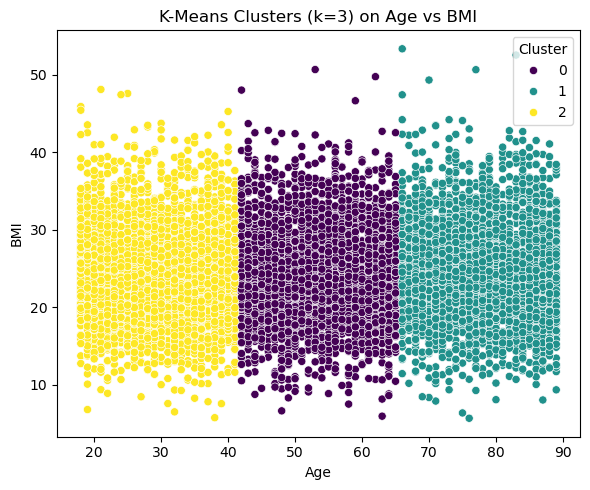

In [16]:

k_opt = 3
kmeans = KMeans(n_clusters=k_opt, n_init=10, random_state=42)
labels_km = kmeans.fit_predict(cluster_df)

plt.figure(figsize=(6,5))
sns.scatterplot(x=cluster_df['Age'], y=cluster_df['BMI'], hue=labels_km, palette='viridis', s=35)
plt.title(f'K-Means Clusters (k={k_opt}) on Age vs BMI')
plt.xlabel('Age')
plt.ylabel('BMI')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

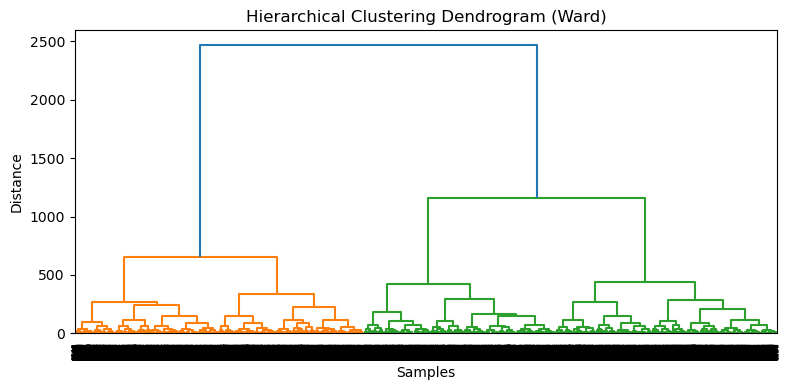

In [17]:
# -- Hierarchical (Agglomerative) + Dendrogram --
# Dendrogram
Z = linkage(cluster_df, method='ward')
plt.figure(figsize=(8,4))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram (Ward)')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

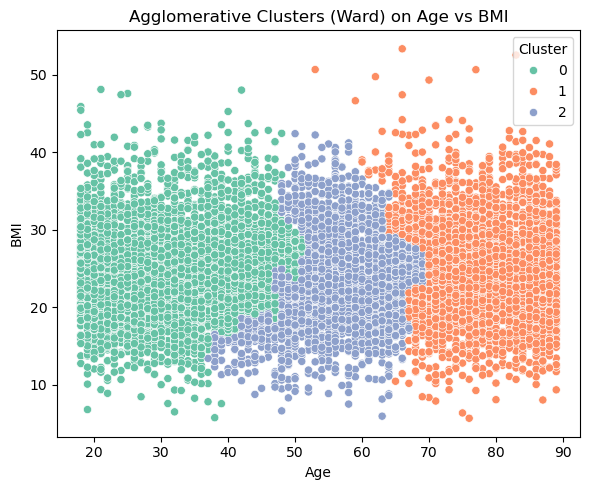

In [19]:
agg = AgglomerativeClustering(n_clusters=3, linkage='ward')
labels_agg = agg.fit_predict(cluster_df)

plt.figure(figsize=(6,5))
sns.scatterplot(x=cluster_df['Age'], y=cluster_df['BMI'], hue=labels_agg, palette='Set2', s=35)
plt.title('Agglomerative Clusters (Ward) on Age vs BMI')
plt.xlabel('Age')
plt.ylabel('BMI')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()